In [11]:
%matplotlib inline
from scipy import linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image
from math import (log,ceil,floor)
from scipy.fft import fft, ifft
from scipy.linalg import dft, inv, expm, norm
from numpy.linalg import matrix_power
import networkx as nx
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout)
from qiskit.circuit.library import QFT
from qiskit.quantum_info.analysis import hellinger_fidelity,hellinger_distance
style = {'figwidth':10,'fontsize':17,'subfontsize':14}
styleWide = {'figwidth':25,'fontsize':17,'subfontsize':14}
styleOracle = {'figwidth':17,'fontsize':20,'subfontsize':20}

plt.rcParams['figure.figsize'] = 11,8
matplotlib.rcParams.update({'font.size' : 15})

import warnings
warnings.filterwarnings("ignore")

In [8]:
def simul(qc,stateVec,shots):
    if stateVec:
        backend = Aer.get_backend('statevector_simulator')
        result = execute(qc,backend,shots=shots).result().get_statevector(qc,decimals=3)
    else:
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc,backend,shots=shots).result().get_counts()
    return result

def decResultDict(n):
    "Retuns a dictionary composed of a range of N keys converted to binary."
    baseDict = {}
    for decNumber in range(2**n):
        dec = decNumber 
        baseDict[dec] = 0
    return baseDict

def normalizedResults(resultsDict,n,shots):
    decDict = decResultDict(n)
    correctedResults = {int(k,2) : v/shots for k,v in resultsDict.items()}
    newDict1 = correctedResults
    newDict2 = decDict
    normalizedResults = {**newDict2,**newDict1}
    return normalizedResults

def diagUniOp(N,diagU0,name):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,name=name)
    diagU0 = list(diagU0)
    circ.diagonal(diagU0,qreg) 
    #circ = transpile(circ)#,optimization_level=3)#,backend=backend,layout_method=method) 
    return circ

def oracleStag(N,markedElements):
    oracleList = np.ones(2**N)
    for element in markedElements:
        oracleList[element] = -1
    return np.array(oracleList,dtype=complex)

def runStagSearch(N,oracleList,theta,steps):
    diffusion = oracleStag(N,[0])
    expDiff = diagUniOp(N,diffusion,'UniOp')
    oracle = diagUniOp(N,oracleList,'Oracle')
    qreg = QuantumRegister(N,'q')
    creg = ClassicalRegister(N,'c')
    walkCirc = QuantumCircuit(qreg,creg)
    walkCirc.h(qreg)
    walkCirc.barrier()
    for i in range(steps):
        walkCirc.append(oracle,qreg)
        walkCirc.h(qreg)
        walkCirc.append(expDiff,qreg)
        walkCirc.h(qreg)
        walkCirc.barrier()
    walkCirc.measure(qreg,creg)
    return walkCirc

def drawUniOp(N):
    diffusion = oracleStag(N,[0])
    expDiff = diagUniOp(N,diffusion,'UniOp')    
    qreg = QuantumRegister(N,'q')
    creg = ClassicalRegister(N,'c')
    qc = QuantumCircuit(qreg,creg)
    qc.h(qreg)
    qc.append(expDiff,qreg)
    qc.h(qreg)
    qc = transpile(qc,basis_gates=['cp','h','cx','rz'])
    return qc

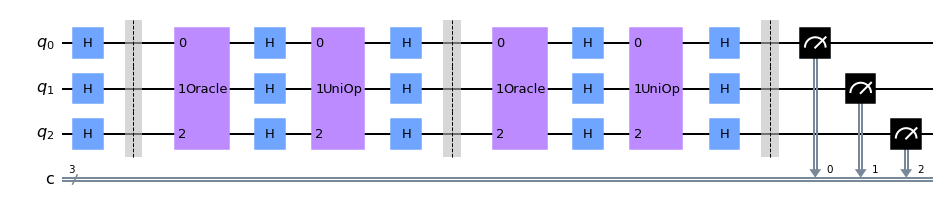

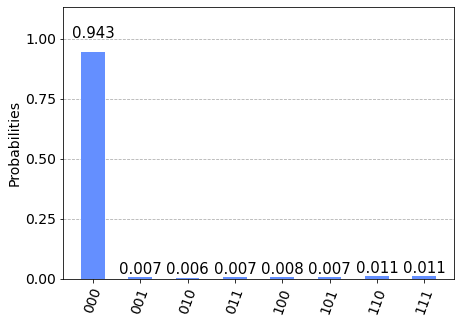

<Figure size 1230.4x264.88 with 0 Axes>

<Figure size 504x360 with 0 Axes>

In [9]:
N = 3
markedElements = [0]
oracleList = oracleStag(N,markedElements)
theta = np.pi/2
steps = 2
stagSearchCirc = runStagSearch(N,oracleList,theta,steps)
display(stagSearchCirc.draw(output='mpl',fold=-1))
plt.clf()
results = simul(stagSearchCirc,False,3000)
display(plot_histogram(results))
plt.clf()

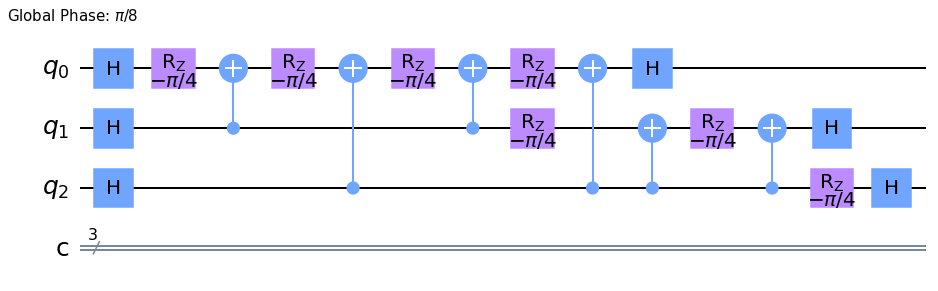

<Figure size 1224x348.842 with 0 Axes>

In [12]:
N = 3
uniOpCirc = drawUniOp(N)
display(uniOpCirc.draw(output='mpl',style=styleOracle))
plt.clf()

## QASM Results

### Mult result functions

In [10]:
def multSQWSearchCirc(N,oracleList,theta,stepList):
    circList = []
    for steps in stepList:
        circ =  runStagSearch(N,oracleList,theta,steps)
        circList.append(circ)
    return circList

def multResultsSim(multipleCircs,shots):
    resultList = []
    result = {}
    correctedResult = {}
    for circ in multipleCircs:
        result = simul(circ,False,shots)
        correctedResult = { int(k,2) : v/shots for k, v in result.items()}
        resultList.append(correctedResult)
        result = {}
    return resultList

def multDecResultDict(N,steps):
    "Returns multiple binary dictionaries."
    baseResultDictList = []
    for step in steps:
        baseDict = decResultDict(N)
        baseResultDictList.append(baseDict)
    return baseResultDictList

def multNormalizedResultDict(baseDictList,qiskitDictList):
    normalizedResultDictList = []
    for baseDict,qiskitDict in zip(baseDictList,qiskitDictList):
        baseDict.update(qiskitDict)
        normalizedResultDictList.append(baseDict)
    return normalizedResultDictList

def multSubPlotIbmSim(resultListIbm,resultListSim,steps,backend):
    "Produces a matplotlib figure composed of several subplots for different numbers of graph nodes and circuit iterations."
    nrows = len(resultListIbm) 
    ncols = 1
    index = 1
    fig = plt.figure()
    axList = []
    auxList = []
    i  = 0
    epsilon = 1e-7
    for resultAuxSim,resultAuxIbm,step in zip(resultListSim,resultListIbm,steps):
        axList.append(fig.add_subplot(nrows,ncols,index))
        if i==0:
            counts1 = [x+epsilon for x in resultAuxSim.values()]
            counts2 = [x+epsilon for x in resultAuxIbm.values()]
            #print(*zip(*enumerate(counts1)))
            axList[-1].set_title("Steps=%s"%step)
            axList[-1].bar(*zip(*enumerate(counts1)),width=-0.4,label = "ibmq_qasm",bottom=0,align='edge')
            axList[-1].bar(*zip(*enumerate(counts2)),width=0.4,label = str(backend),bottom=0,align='edge')
            axList[-1].legend()
        else:
            counts1 = [x+epsilon for x in resultAuxSim.values()]
            counts2 = [x+epsilon for x in resultAuxIbm.values()]
            axList[-1].set_title("Steps=%s"%step)
            #print(*zip(*enumerate(counts1)))
            axList[-1].bar(*zip(*enumerate(counts1)),width=-0.4,bottom=0,align='edge')
            axList[-1].bar(*zip(*enumerate(counts2)),width=0.4,bottom=0,align='edge')
        i+=1
        index+=1
        counts1= []
        counts2= []
    for ax in axList:
        axList[0].get_shared_y_axes().join(axList[0],ax)
    #for ax in axList:
    #    ax.set_xticklabels([])
    axList[-1].set_xticklabels(resultListIbm[-1].keys(),rotation=45)
    plt.xlabel("Graph Node")
    plt.ylabel("Probability")
    fig.tight_layout(pad=1.0)
    return axList 

def multSubPlotSim(resultListSim,steps):
    Tot = len(steps)
    Cols = 1
    # Compute Rows required
    Rows = Tot // Cols
    Rows += Tot % Cols
    # Create a Position index
    Position = range(1,Tot + 1)
    fig = plt.figure(1)
    #mpl.rcParams.update(mpl.rcParamsDefault)
    #mpl.rcParams['figure.figsize'] = 11,8
    #mpl.rcParams.update({'font.size' : 15})
    i = 0
    for k,resultDictSim,step in zip(range(Tot),resultListSim,steps):
            countsSim = resultDictSim.values()
            ax = fig.add_subplot(Rows,Cols,Position[k])
            if i ==0:
                ax.set_title("Steps=%s"%step)
                ax.bar(*zip(*enumerate(countsSim)),width=0.4,bottom=0,align='edge',label='qasm_simulator')
                ax.legend()
            else:
                ax.set_title("Steps=%s"%step)
                ax.bar(*zip(*enumerate(countsSim)),width=0.4,bottom=0,align='edge')
            plt.ylim(0,1.2)
            plt.yticks([0,0.5,1])
            plt.xlim(0-1,len(countsSim))
            w = ax.get_xaxis()
            if(i==Tot-1):
                w.set_visible(True)
                plt.xticks(range(0,len(countsSim)))
            else:
                w.set_visible(False)
            i+=1
    plt.xlabel("Graph Node")
    plt.ylabel("Probability")
    fig.tight_layout(pad=1.0)
    

def plotMultipleQiskit(N,multipleCircs,steps,shots):
    qiskitSimResultList = multResultsSim(multipleCircs,shots)
    baseDictList = multDecResultDict(N,steps)
    normalizedResultDictList = multNormalizedResultDict(baseDictList,qiskitSimResultList)
    fig = multSubPlotSim(normalizedResultDictList,steps)
    return fig

def plotMultipleQiskitIbmSim(N,multipleCircs,ibmJobDictList,steps,shots,Decimal,backend):
    "Brings every dictionar and plot building functions together to either show or save the matplotlib figure."
    #formatedIbmList = formatResultIBM(ibmJobDictList,shots,Decimal)
    formatedSimList = multResultsSim(multipleCircs,shots)
    if Decimal:
        baseDictList = multDecResultDict(N,steps)
    else:
        baseDictList = multBinResultDict(N,steps)
    #normalizedResultListIbm = multNormalizedResultDict(baseDictList,ibmJobDictList)
    normalizedResultListSim = multNormalizedResultDict(baseDictList,formatedSimList)
    print("normalizedResultListIbm %s"%ibmJobDictList)
    print()
    print("normalizedResultListSim %s"%normalizedResultListSim)
    fig = multSubPlotIbmSim(ibmJobDictList,normalizedResultListSim,steps,backend)
    return fig

In [11]:
N = 3
markedElements = [4]
oracleList = oracleStag(N,markedElements)
theta = np.pi/2
stepList = [0,1,2,3]
shots = 3000
multipleCircs = multSQWSearchCirc(N,oracleList,theta,stepList)
#plotMultipleQiskit(N,multipleCircs,stepList,shots)
multResultSimN3 = multResultsSim(multipleCircs,shots)
print(multResultSimN3)

[{5: 0.13033333333333333, 4: 0.12966666666666668, 6: 0.12866666666666668, 2: 0.11666666666666667, 1: 0.12, 0: 0.12933333333333333, 7: 0.119, 3: 0.12633333333333333}, {2: 0.03166666666666667, 6: 0.03766666666666667, 4: 0.7796666666666666, 5: 0.033666666666666664, 1: 0.027666666666666666, 3: 0.028333333333333332, 0: 0.03133333333333333, 7: 0.03}, {2: 0.007333333333333333, 6: 0.006, 4: 0.9486666666666667, 5: 0.006333333333333333, 1: 0.007, 0: 0.007, 3: 0.007333333333333333, 7: 0.010333333333333333}, {2: 0.096, 5: 0.09266666666666666, 1: 0.10033333333333333, 3: 0.08933333333333333, 0: 0.097, 7: 0.08633333333333333, 6: 0.10166666666666667, 4: 0.33666666666666667}]


## IBM Results

In [12]:
IBMQ.save_account('97d2733b7c11b188b0581ae8a2beda54ce1c210ae0274df456ec1ddbe7df9fddf6d104015c59d4f7ce651304bf82fbd8e7178ea759d5f6f8058950d9e7ebf2ad')
IBMQ.load_account()
def getJob(jobID,provider,backend):
    job = backend.retrieve_job(jobID)
    resultCount = job.result().get_counts()
    return resultCount

def setProvider(hub,group,project):
    provider = IBMQ.get_provider(hub=hub, group=group, project=project)
    return provider

def leastBusy(minQubits,provider):
    large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits > minQubits  and not x.configuration().simulator)
    leastBusybackend = least_busy(large_enough_devices)
    return leastBusybackend

def listBackends(provider):
    for backend in provider.backends():
        print( backend.name())

def getJob(jobID,provider,backend):
    job = backend.retrieve_job(jobID)
    resultCount = job.result().get_counts()
    return resultCount

def run(circuit, backend, **kwargs):
    if type(backend) is str:
        backend = Aer.get_backend(backend)
    return execute(circuit, backend, **kwargs)

def printBestSeed(qc,basisGatesD,deviceBackend,startSeed,endSeed):
    dict = {}
    dict2 = {}
    for i in range(startSeed,endSeed):
        qCirc = transpile(qc,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,layout_method='noise_adaptive',seed_transpiler=i)
        dict[i] = qCirc.count_ops()['cx']
        dict2[i] = qCirc.depth()
    print(min(dict.items(), key=lambda x: x[1])) 
    print(min(dict2.items(), key=lambda x: x[1]))

configrc.store_credentials:WARNING:2021-07-04 21:18:28,151: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-07-04 21:18:28,673: Credentials are already in use. The existing account in the session will be replaced.


In [13]:
provider = setProvider('ibm-q-minho','academicprojects','quantalab')
##leastBusyBackend =leastBusy(10,provider)
##print("Least busy backend:",leastBusyBackend)
##32QV
bogBackend = provider.get_backend('ibmq_bogota')
parisBackend = provider.get_backend('ibmq_paris')
manhatBackend = provider.get_backend('ibmq_manhattan')
torontoBackend = provider.get_backend('ibmq_toronto')
mumbaiBackend = provider.get_backend('ibmq_mumbai')
casablancaBackend = provider.get_backend('ibmq_casablanca')
yorkTown = provider.get_backend('ibmq_5_yorktown')
manila = provider.get_backend('ibmq_manila')
santiago = provider.get_backend('ibmq_santiago')
montreal = provider.get_backend('ibmq_montreal')


##Chosen
backend = santiago
backend2 = manila
backend3 = torontoBackend
backend4 = mumbaiBackend
backend5 = montreal
mumbaiGates = ['cx', 'id', 'rz', 'sx', 'x']
torontoGates = ['cx', 'id', 'rz', 'sx', 'x']

#simulator = provider.get_backend('ibmq_qasm_simulator')
#method = 'noise_adaptive'
method = 'noise_adaptive'
#basisGatesD=['cx','rz','h','u3']
#printBestSeed(groverCircN3M0,basisGatesD,backend,0,100)

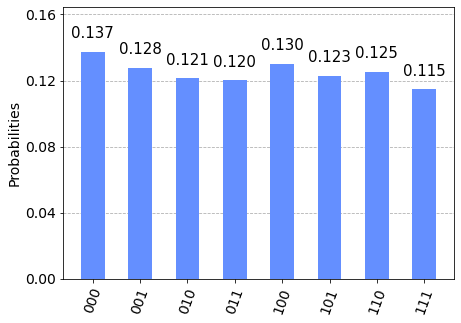

<Figure size 792x576 with 0 Axes>

<Figure size 504x360 with 0 Axes>

In [14]:
N = 3
markedElements = [0]
oracleList = oracleStag(N,markedElements)
theta = np.pi/2
steps = 0
stagSearchCirc = runStagSearch(N,oracleList,theta,steps)
stagSearchCirc = transpile(stagSearchCirc,backend4,basis_gates = mumbaiGates,layout_method=method)
#display(stagSearchCirc.draw(output='mpl',fold=-1))
plt.clf()
results = simul(stagSearchCirc,False,3000)
display(plot_histogram(results))
plt.clf()

In [15]:
def runStagSearchForIBM(N,oracleList,theta,steps,backend,method,gates):
    diffusion = oracleStag(N,[0])
    expDiff = diagUniOp(N,diffusion,'UniOp')
    oracle = diagUniOp(N,oracleList,'Oracle')
    qreg = QuantumRegister(N,'q')
    creg = ClassicalRegister(N,'c')
    walkCirc = QuantumCircuit(qreg,creg)
    walkCirc.h(qreg)
    walkCirc.barrier()
    for i in range(steps):
        walkCirc.append(oracle,qreg)
        walkCirc.h(qreg)
        walkCirc.append(expDiff,qreg)
        walkCirc.h(qreg)
        walkCirc.barrier()
    walkCirc.measure(qreg,creg)
    walkCirc = transpile(walkCirc,backend,basis_gates = gates,layout_method=method,optimization_level=3)
    return walkCirc

def executeStagSearch(backend,method,gates,N,oracleList,theta,stepList,shots):
    #jobName = 'stagSearch_'+str(backend)+'_N'+str(N)+'_S'
    retrievedJobList = []
    for step in stepList:
        #jobName += str(step)
        circ = runStagSearchForIBM(N,oracleList,theta,step,backend,method,gates)
        job = execute([circ]*10,backend,shots=shots)
        #jobName = 'stagSearch_'+str(backend)+'_N'+str(N)+'_S'
        retrievedJob = backend.retrieve_job(job.job_id())
        retrievedJobList.append(retrievedJob)
    return retrievedJobList

def getJobIds(jobList):
    jobIdList = []
    for job in jobList:
        jobIdList.append(job.job_id())
    return jobIdList

def retrieveJobsFromId(jobIdList,backend):
    retrievedJobList = []
    for jobId in jobIdList:
        retrievedJob = backend.retrieve_job(jobId)
        retrievedJobList.append(retrievedJob)
    return retrievedJobList

def getJobResults(jobList):
    multipleCountList = []
    for job in jobList:
        multipleCountList.append(job.result().get_counts())
    return multipleCountList

def multDictResults(resultList):
    multResultList = []
    avgValue = 0
    for result in resultList:
        newResult = []
        for counts in result:
            correctedResult = { int(k,2) : v/shots for k, v in counts.items()}
            newResult.append(correctedResult)
        multResultList.append(newResult)
    return multResultList

### Toronto

In [58]:
N = 3
markedElements = [4]
shots = 3000
oracleList = oracleStag(N,markedElements)
theta = np.pi/2
stepList = [0,1,2,3]
method = 'noise_adaptive'
jobList = executeStagSearch(backend3,method,torontoGates,N,oracleList,theta,stepList,shots)

In [16]:
jobIds = getJobIds(jobList)
print(jobIds)

NameError: name 'jobList' is not defined

In [18]:
torontoStagSearchIdList = ['60e1e0732dfe6d4d39b9a621', '60e1e075e7864582591f7772', '60e1e079e0ccebde7a7ea971', '60e1e07c2dfe6d0cccb9a622']
retrievedJobs = retrieveJobsFromId(torontoStagSearchIdList,backend3)

In [19]:
resultList = getJobResults(retrievedJobs)

In [20]:
correctedResults = multDictResults(resultList)

In [23]:
def fidDictList(results,multResultsSim):
    resultListFid = []
    resultListListFid = []
    for results,resultsSim in zip(correctedResults,multResultsSim):
        for resultDict in results:
            #print("IBM %s"%resultDict)
            #print("Sim %s"%resultsSim)
            hFid = (1-(hellinger_distance(resultsSim,resultDict))**2)
            #print("Hellinger fid %s"%(1-(hellinger_distance(resultsSim,resultDict))**2))
            resultListFid.append((resultDict,hFid))
        resultListListFid.append(resultListFid)
        resultListFid = []
    return resultListListFid

def maxFidIbmResultDict(results,multResultsSim):
    resultListFid = fidDictList(results,multResultsSim)
    maxFidDictList = []
    for a in resultListFid:
        maxFidDict = max(a,key=lambda x:x[1])
        maxFidDictList.append(maxFidDict[0])
        print(maxFidDict)
    return maxFidDictList

maxFidDict = maxFidIbmResultDict(results,multResultSimN3)
#print(maxFidDict)
#print()
#print(multResultSimN3)

({0: 0.13566666666666666, 1: 0.152, 2: 0.12833333333333333, 3: 0.13833333333333334, 4: 0.108, 5: 0.11666666666666667, 6: 0.10633333333333334, 7: 0.11466666666666667}, 0.9975067029059385)
({0: 0.09766666666666667, 1: 0.073, 2: 0.071, 3: 0.05333333333333334, 4: 0.498, 5: 0.067, 6: 0.086, 7: 0.054}, 0.9543241689485811)
({0: 0.094, 1: 0.091, 2: 0.08066666666666666, 3: 0.07633333333333334, 4: 0.38366666666666666, 5: 0.118, 6: 0.07666666666666666, 7: 0.07966666666666666}, 0.7796495019322955)
({0: 0.129, 1: 0.11, 2: 0.11533333333333333, 3: 0.11166666666666666, 4: 0.19466666666666665, 5: 0.12966666666666668, 6: 0.10633333333333334, 7: 0.10333333333333333}, 0.9860637675209298)


normalizedResultListIbm [{0: 0.13566666666666666, 1: 0.152, 2: 0.12833333333333333, 3: 0.13833333333333334, 4: 0.108, 5: 0.11666666666666667, 6: 0.10633333333333334, 7: 0.11466666666666667}, {0: 0.09766666666666667, 1: 0.073, 2: 0.071, 3: 0.05333333333333334, 4: 0.498, 5: 0.067, 6: 0.086, 7: 0.054}, {0: 0.094, 1: 0.091, 2: 0.08066666666666666, 3: 0.07633333333333334, 4: 0.38366666666666666, 5: 0.118, 6: 0.07666666666666666, 7: 0.07966666666666666}, {0: 0.129, 1: 0.11, 2: 0.11533333333333333, 3: 0.11166666666666666, 4: 0.19466666666666665, 5: 0.12966666666666668, 6: 0.10633333333333334, 7: 0.10333333333333333}]

normalizedResultListSim [{0: 0.125, 1: 0.132, 2: 0.132, 3: 0.12266666666666666, 4: 0.124, 5: 0.11433333333333333, 6: 0.123, 7: 0.127}, {0: 0.036, 1: 0.035333333333333335, 2: 0.038, 3: 0.03133333333333333, 4: 0.7606666666666667, 5: 0.034333333333333334, 6: 0.03133333333333333, 7: 0.033}, {0: 0.01, 1: 0.011, 2: 0.011333333333333334, 3: 0.008666666666666666, 4: 0.933, 5: 0.00733333

[<AxesSubplot:title={'center':'Steps=0'}>,
 <AxesSubplot:title={'center':'Steps=1'}>,
 <AxesSubplot:title={'center':'Steps=2'}>,
 <AxesSubplot:title={'center':'Steps=3'}, xlabel='Graph Node', ylabel='Probability'>]

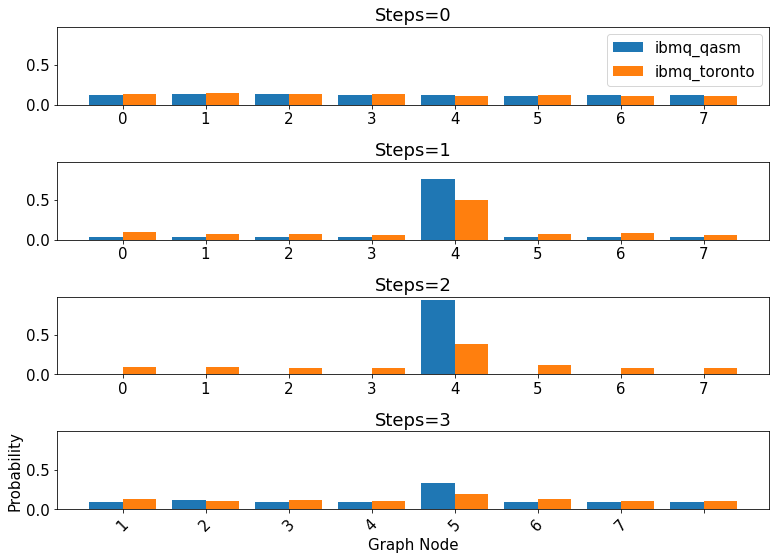

In [22]:
plotMultipleQiskitIbmSim(N,multipleCircs,maxFidDict,stepList,shots,True,backend3)

### Mumbai

In [49]:
N = 3
markedElements = [4]
shots = 3000
oracleList = oracleStag(N,markedElements)
theta = np.pi/2
stepList = [0,1,2,3]
method = 'noise_adaptive'
jobList = executeStagSearch(backend4,method,mumbaiGates,N,oracleList,theta,stepList,shots)

In [51]:
jobIds = getJobIds(jobList)
print(jobIds)

['60e1df035d97d0389aff5c32', '60e1df05e7864564181f775d', '60e1df086e449a490e4fcab1', '60e1df0b6e449a21484fcab2']


In [52]:
mumbaiStagSearchIdList = ['60e1df035d97d0389aff5c32', '60e1df05e7864564181f775d', '60e1df086e449a490e4fcab1', '60e1df0b6e449a21484fcab2']
retrievedJobs = retrieveJobsFromId(mumbaiStagSearchIdList,backend4)

In [53]:
resultList = getJobResults(retrievedJobs)

In [54]:
correctedResults = multDictResults(resultList)

In [55]:
for results in correctedResults:
    print(results)
    print()

[{0: 0.12733333333333333, 1: 0.12266666666666666, 2: 0.132, 3: 0.12, 4: 0.12033333333333333, 5: 0.128, 6: 0.12066666666666667, 7: 0.129}, {0: 0.13666666666666666, 1: 0.115, 2: 0.13, 3: 0.12933333333333333, 4: 0.127, 5: 0.11366666666666667, 6: 0.12333333333333334, 7: 0.125}, {0: 0.12333333333333334, 1: 0.12533333333333332, 2: 0.12133333333333333, 3: 0.13266666666666665, 4: 0.11133333333333334, 5: 0.133, 6: 0.13, 7: 0.123}, {0: 0.12933333333333333, 1: 0.12166666666666667, 2: 0.12166666666666667, 3: 0.126, 4: 0.12333333333333334, 5: 0.12133333333333333, 6: 0.13, 7: 0.12666666666666668}, {0: 0.12166666666666667, 1: 0.12133333333333333, 2: 0.11333333333333333, 3: 0.13366666666666666, 4: 0.129, 5: 0.12733333333333333, 6: 0.122, 7: 0.13166666666666665}, {0: 0.12933333333333333, 1: 0.12533333333333332, 2: 0.12833333333333333, 3: 0.11633333333333333, 4: 0.12966666666666668, 5: 0.13133333333333333, 6: 0.125, 7: 0.11466666666666667}, {0: 0.126, 1: 0.12466666666666666, 2: 0.114, 3: 0.1243333333333